## Executive Summary: 
In Australia the public school zone property prices are very high compare to outside the catchment zone in the same suburb.  In Top 20 school catchment zones are considerably higher and this makes difficult for parents to buy property in that school zones due to affordability.  So the question often from the parents are whether to buy a property in the top public school area with higher price or to send their kids to Private school. 

The project is to find the following:

1. Property Median Price : Property median price in the top 50 public school catchment zone vs outside catchment zone in the same suburb.
Example: Balywin North Victoria
a) What is the median price for house ( exclude unit , apartment if the data permit) in the catchment zone
b) What is the median price for house ( exclude unit , apartment if the data permit) outside catchment zone
c) What is the difference in median price for house Inside the catchment zone Vs outside the catchment zone.


Solution:



Property price Variation and private school fee:  A parent should be able to identify the % wise difference as well as the absolute number terms difference in the top 10/20 school zone property prices so that they can compare the private school fee in the state. The Average private school fee in the state is (25000 per year approx.. )


## Datasets
In this project I am using 4 datasets. 
1. Melbourne Housing , (house)
2. Schools with details of  public schools in victoria.(schools)
3. School Zone, a geojason file with different school zones as polygons.(geoschool)
4. Top public schools list in excel file(school_rank_list)


## import statements

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pysal

from tqdm.autonotebook import tqdm
#from geopandas.tools import geocode
#from shapely.geometry import Point
from geopy.exc import GeocoderTimedOut
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint
import os
import folium
from matplotlib.collections import PatchCollection

from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

#Importing Bokeh for map
import pandas_bokeh
pandas_bokeh.output_notebook()
from bokeh.models import BoxSelectTool


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category = FutureWarning)

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')


/anaconda3/envs/geoenv/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
/anaconda3/envs/geoenv/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Loading BokehJS ...

## Loading the excel file with school rankings

In [3]:

df = pd.read_excel ('school_rankings_new.xls') 

school_ranking = pd.DataFrame(df, columns= ['Ranking','School Name','State','School Sector','Score'])


In [4]:
#Put top 30 schools into a list

school_rank_list= school_ranking['School Name'].tolist()



## Loading the housing data with geospatial information

In [5]:
#code to find longitude and latitude mentioned in notebook 'capstone_house_find_latitude'

data= 'HousePrices_with_longitude.csv'



In [6]:

house= pd.read_csv(data)
house.shape


(63023, 19)

In [7]:
house.head(10)

Unnamed: 0        Suburb            Address  Rooms Type      Price Method  \
0           0    Abbotsford      49 Lithgow St      3    h  1490000.0      S   
1           1    Abbotsford      59A Turner St      3    h  1220000.0      S   
2           2    Abbotsford      119B Yarra St      3    h  1420000.0      S   
3           3    Aberfeldie         68 Vida St      3    h  1515000.0      S   
4           4  Airport West   92 Clydesdale Rd      2    h   670000.0      S   
5           5  Airport West       4/32 Earl St      2    t   530000.0      S   
6           6  Airport West     3/74 Hawker St      2    u   540000.0      S   
7           7  Airport West  1/26 Highridge Cr      3    h   715000.0     SP   
8           8     Albanvale      1 Jackson Cct      6    h        NaN     PI   
9           9   Albert Park        18 Mills St      3    h  1925000.0      S   

         SellerG       Date  Postcode             Regionname  Propertycount  \
0         Jellis  1/04/2017      3067  Northern Metropolitan           4019   
1       Marshall  1/04/2017      3067  Northern Metropolitan           4019   
2         Nelson  1/04/2017      3067  Northern Metropolitan           4019   
3          Barry  1/04/2017      3040   Western Metropolitan           1543   
4         Nelson  1/04/2017      3042   Western Metropolitan           3464   
5         Jellis  1/04/2017      3042   Western Metropolitan           3464   
6          Barry  1/04/2017      3042   Western Metropolitan           3464   
7         Nelson  1/04/2017      3042   Western Metropolitan           3464   
8  hockingstuart  1/04/2017      3021   Western Metropolitan           1899   
9         Cayzer  1/04/2017      3206  Southern Metropolitan           3280   

   Distance                 CouncilArea  \
0       3.0          Yarra City Council   
1       3.0          Yarra City Council   
2       3.0          Yarra City Council   
3       7.5  Moonee Valley City Council   
4      10.4  Moonee Valley City Council   
5      10.4  Moonee Valley City Council   
6      10.4  Moonee Valley City Council   
7      10.4  Moonee Valley City Council   
8      14.0       Brimbank City Council   
9       3.0   Port Phillip City Council   

                                             address  lat        long  \
0   49 Lithgow St,Abbotsford,3067,Victoria,Australia    0         NaN   
1   59A Turner St,Abbotsford,3067,Victoria,Australia    0  144.993265   
2   119B Yarra St,Abbotsford,3067,Victoria,Australia    0  144.997296   
3      68 Vida St,Aberfeldie,3040,Victoria,Australia    0  144.898196   
4  92 Clydesdale Rd,Airport West,3042,Victoria,Au...    0  144.879006   
5  4/32 Earl St,Airport West,3042,Victoria,Australia    0  144.886105   
6  3/74 Hawker St,Airport West,3042,Victoria,Aust...    0  144.886400   
7  1/26 Highridge Cr,Airport West,3042,Victoria,A...    0  144.883228   
8    1 Jackson Cct,Albanvale,3021,Victoria,Australia    0  144.768013   
9    18 Mills St,Albert Park,3206,Victoria,Australia    0  144.960401   

    latitude   longitude  
0 -37.807452  144.998738  
1 -37.798891  144.993265  
2 -37.802307  144.997296  
3 -37.758746  144.898196  
4 -37.727649  144.879006  
5 -37.727154  144.886105  
6 -37.722207  144.886400  
7 -37.726406  144.883228  
8 -37.741453  144.768013  
9 -37.844039  144.960401

In [8]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 19 columns):
Unnamed: 0       63023 non-null int64
Suburb           63023 non-null object
Address          63023 non-null object
Rooms            63023 non-null int64
Type             63023 non-null object
Price            48433 non-null float64
Method           63023 non-null object
SellerG          63023 non-null object
Date             63023 non-null object
Postcode         63023 non-null int64
Regionname       63023 non-null object
Propertycount    63023 non-null int64
Distance         63023 non-null float64
CouncilArea      63023 non-null object
address          63023 non-null object
lat              63023 non-null int64
long             9 non-null float64
latitude         63023 non-null float64
longitude        63023 non-null float64
dtypes: float64(5), int64(5), object(9)
memory usage: 9.1+ MB


In [9]:
house.drop(['Unnamed: 0','lat','long'],axis=1,inplace=True)

In [10]:

from shapely.geometry import Point
#dropping the rows with no price
house = house[house.Price.notna()]

geometry = [Point(xy) for xy in zip(house.longitude,house.latitude)]

house = gpd.GeoDataFrame(house, geometry=geometry)
# 

In [11]:
# house[['longitude', 'latitude']].apply(lambda x : Point(x.longitude, x.latitude))

In [12]:
house.head(10)


Suburb             Address  Rooms Type      Price Method   SellerG  \
0     Abbotsford       49 Lithgow St      3    h  1490000.0      S    Jellis   
1     Abbotsford       59A Turner St      3    h  1220000.0      S  Marshall   
2     Abbotsford       119B Yarra St      3    h  1420000.0      S    Nelson   
3     Aberfeldie          68 Vida St      3    h  1515000.0      S     Barry   
4   Airport West    92 Clydesdale Rd      2    h   670000.0      S    Nelson   
5   Airport West        4/32 Earl St      2    t   530000.0      S    Jellis   
6   Airport West      3/74 Hawker St      2    u   540000.0      S     Barry   
7   Airport West   1/26 Highridge Cr      3    h   715000.0     SP    Nelson   
9    Albert Park         18 Mills St      3    h  1925000.0      S    Cayzer   
10        Albion  3/15 Drummartin St      3    u   515000.0      S   Douglas   

         Date  Postcode             Regionname  Propertycount  Distance  \
0   1/04/2017      3067  Northern Metropolitan           4019       3.0   
1   1/04/2017      3067  Northern Metropolitan           4019       3.0   
2   1/04/2017      3067  Northern Metropolitan           4019       3.0   
3   1/04/2017      3040   Western Metropolitan           1543       7.5   
4   1/04/2017      3042   Western Metropolitan           3464      10.4   
5   1/04/2017      3042   Western Metropolitan           3464      10.4   
6   1/04/2017      3042   Western Metropolitan           3464      10.4   
7   1/04/2017      3042   Western Metropolitan           3464      10.4   
9   1/04/2017      3206  Southern Metropolitan           3280       3.0   
10  1/04/2017      3020   Western Metropolitan           2185      10.5   

                   CouncilArea  \
0           Yarra City Council   
1           Yarra City Council   
2           Yarra City Council   
3   Moonee Valley City Council   
4   Moonee Valley City Council   
5   Moonee Valley City Council   
6   Moonee Valley City Council   
7   Moonee Valley City Council   
9    Port Phillip City Council   
10       Brimbank City Council   

                                              address   latitude   longitude  \
0    49 Lithgow St,Abbotsford,3067,Victoria,Australia -37.807452  144.998738   
1    59A Turner St,Abbotsford,3067,Victoria,Australia -37.798891  144.993265   
2    119B Yarra St,Abbotsford,3067,Victoria,Australia -37.802307  144.997296   
3       68 Vida St,Aberfeldie,3040,Victoria,Australia -37.758746  144.898196   
4   92 Clydesdale Rd,Airport West,3042,Victoria,Au... -37.727649  144.879006   
5   4/32 Earl St,Airport West,3042,Victoria,Australia -37.727154  144.886105   
6   3/74 Hawker St,Airport West,3042,Victoria,Aust... -37.722207  144.886400   
7   1/26 Highridge Cr,Airport West,3042,Victoria,A... -37.726406  144.883228   
9     18 Mills St,Albert Park,3206,Victoria,Australia -37.844039  144.960401   
10  3/15 Drummartin St,Albion,3020,Victoria,Australia -37.782859  144.822286   

                                  geometry  
0   POINT (144.9987375 -37.80745220000001)  
1          POINT (144.9932646 -37.7988906)  
2          POINT (144.9972956 -37.8023074)  
3           POINT (144.8981962 -37.758746)  
4            POINT (144.879006 -37.727649)  
5          POINT (144.8861054 -37.7271544)  
6          POINT (144.8863999 -37.7222069)  
7   POINT (144.8832275 -37.72640560000001)  
9   POINT (144.9604014 -37.84403889999999)  
10         POINT (144.8222862 -37.7828591)

In [13]:
# Dropping the rows with no price


In [14]:
house.drop(['SellerG','Method'],axis=1,inplace=True)

In [15]:
#house[house['Suburb']=='Avonsleigh']

In [16]:
house

Suburb           Address  Rooms Type      Price        Date  \
0         Abbotsford     49 Lithgow St      3    h  1490000.0   1/04/2017   
1         Abbotsford     59A Turner St      3    h  1220000.0   1/04/2017   
2         Abbotsford     119B Yarra St      3    h  1420000.0   1/04/2017   
3         Aberfeldie        68 Vida St      3    h  1515000.0   1/04/2017   
4       Airport West  92 Clydesdale Rd      2    h   670000.0   1/04/2017   
...              ...               ...    ...  ...        ...         ...   
63016      Frankston    4/34 Petrie St      2    u   347700.0  31/03/2018   
63017        Preston     229 Murray Rd      3    h   808000.0  31/03/2018   
63018  Roxburgh Park         3 Carr Pl      3    h   566000.0  31/03/2018   
63019  Roxburgh Park       9 Parker Ct      3    h   500000.0  31/03/2018   
63020  Roxburgh Park    5 Parkinson Wy      3    h   545000.0  31/03/2018   

       Postcode                  Regionname  Propertycount  Distance  \
0          3067       Northern Metropolitan           4019       3.0   
1          3067       Northern Metropolitan           4019       3.0   
2          3067       Northern Metropolitan           4019       3.0   
3          3040        Western Metropolitan           1543       7.5   
4          3042        Western Metropolitan           3464      10.4   
...         ...                         ...            ...       ...   
63016      3199  South-Eastern Metropolitan          17055      38.0   
63017      3072       Northern Metropolitan          14577       8.4   
63018      3064       Northern Metropolitan           5833      20.6   
63019      3064       Northern Metropolitan           5833      20.6   
63020      3064       Northern Metropolitan           5833      20.6   

                      CouncilArea  \
0              Yarra City Council   
1              Yarra City Council   
2              Yarra City Council   
3      Moonee Valley City Council   
4      Moonee Valley City Council   
...                           ...   
63016      Frankston City Council   
63017        Darebin City Council   
63018           Hume City Council   
63019           Hume City Council   
63020           Hume City Council   

                                                 address   latitude  \
0       49 Lithgow St,Abbotsford,3067,Victoria,Australia -37.807452   
1       59A Turner St,Abbotsford,3067,Victoria,Australia -37.798891   
2       119B Yarra St,Abbotsford,3067,Victoria,Australia -37.802307   
3          68 Vida St,Aberfeldie,3040,Victoria,Australia -37.758746   
4      92 Clydesdale Rd,Airport West,3042,Victoria,Au... -37.727649   
...                                                  ...        ...   
63016   4/34 Petrie St,Frankston,3199,Victoria,Australia -38.139970   
63017      229 Murray Rd,Preston,3072,Victoria,Australia -37.738301   
63018    3 Carr Pl,Roxburgh Park,3064,Victoria,Australia -37.634836   
63019  9 Parker Ct,Roxburgh Park,3064,Victoria,Australia -37.633182   
63020  5 Parkinson Wy,Roxburgh Park,3064,Victoria,Aus... -37.639353   

        longitude                                    geometry  
0      144.998738      POINT (144.9987375 -37.80745220000001)  
1      144.993265             POINT (144.9932646 -37.7988906)  
2      144.997296             POINT (144.9972956 -37.8023074)  
3      144.898196              POINT (144.8981962 -37.758746)  
4      144.879006               POINT (144.879006 -37.727649)  
...           ...                                         ...  
63016  145.130483             POINT (145.1304835 -38.1399699)  
63017  145.005788  POINT (145.005788413513 -37.7383013459459)  
63018  144.930703             POINT (144.9307033 -37.6348359)  
63019  144.923281             POINT (144.9232808 -37.6331821)  
63020  144.926449             POINT (144.9264486 -37.6393525)  

[48433 rows x 15 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23d9e0d0>,
      dtype=object)

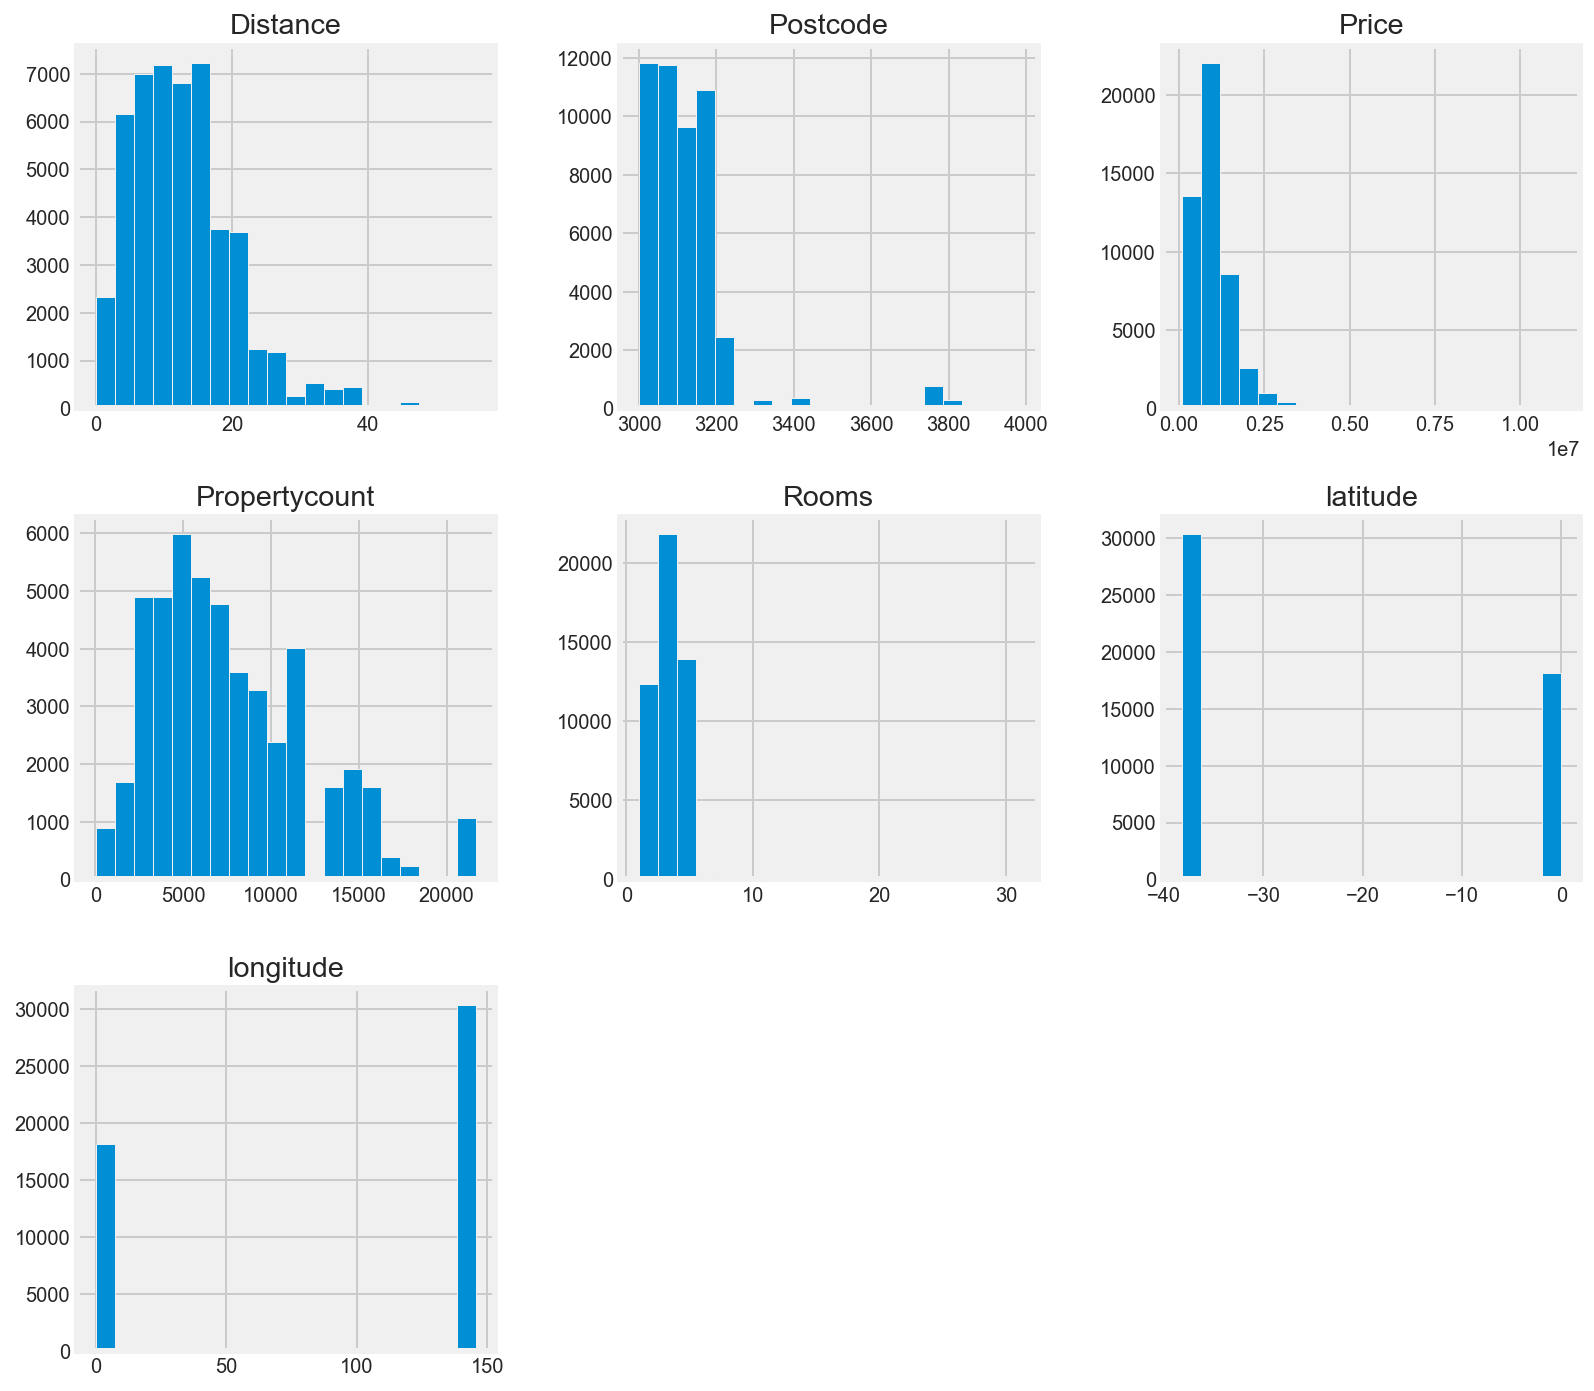

In [17]:




#Basic plot to view the distribution of data

house.hist(bins=20, figsize=(12,12))
#plt.show()

In [18]:
df1=house.groupby('Regionname')['Price'].median()
df1

Regionname
Eastern Metropolitan           990000.0
Eastern Victoria               670000.0
Northern Metropolitan          715000.0
Northern Victoria              590000.0
South-Eastern Metropolitan     780000.0
Southern Metropolitan         1230000.0
Western Metropolitan           700000.0
Western Victoria               400000.0
Name: Price, dtype: float64

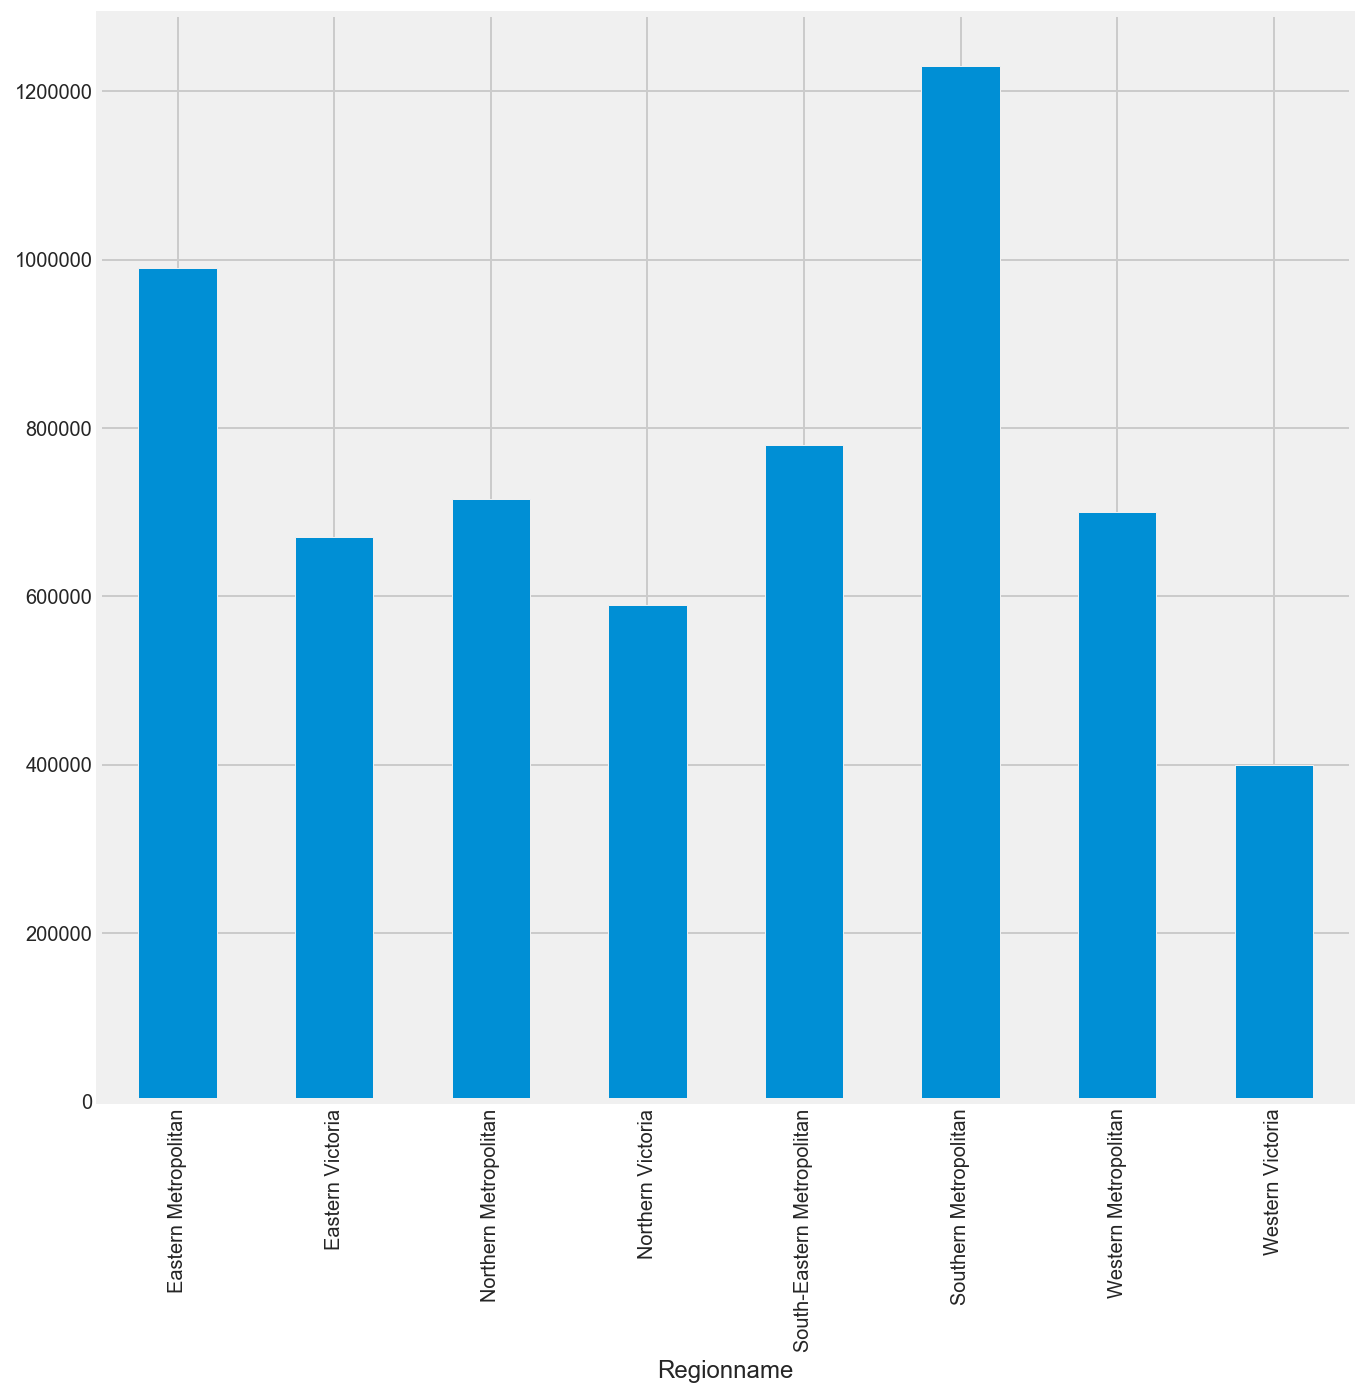

In [19]:
df1.plot(kind= 'bar',figsize=(10,10))

In [20]:
df1=house.groupby('CouncilArea')['Price'].median()
df1

CouncilArea
Banyule City Council               805000.0
Bayside City Council              1320000.0
Boroondara City Council           1580000.0
Brimbank City Council              650000.0
Cardinia Shire Council             522750.0
Casey City Council                 613000.0
Darebin City Council               830000.0
Frankston City Council             610000.0
Glen Eira City Council            1150000.0
Greater Dandenong City Council     670000.0
Hobsons Bay City Council           900000.0
Hume City Council                  565000.0
Kingston City Council              875000.0
Knox City Council                  822000.0
Macedon Ranges Shire Council       695000.0
Manningham City Council           1170000.0
Maribyrnong City Council           815000.0
Maroondah City Council             820000.0
Melbourne City Council             860000.0
Melton City Council                490000.0
Mitchell Shire Council             484000.0
Monash City Council               1113000.0
Moonee Valley City C

Text(0, 0.5, 'Median House Price')

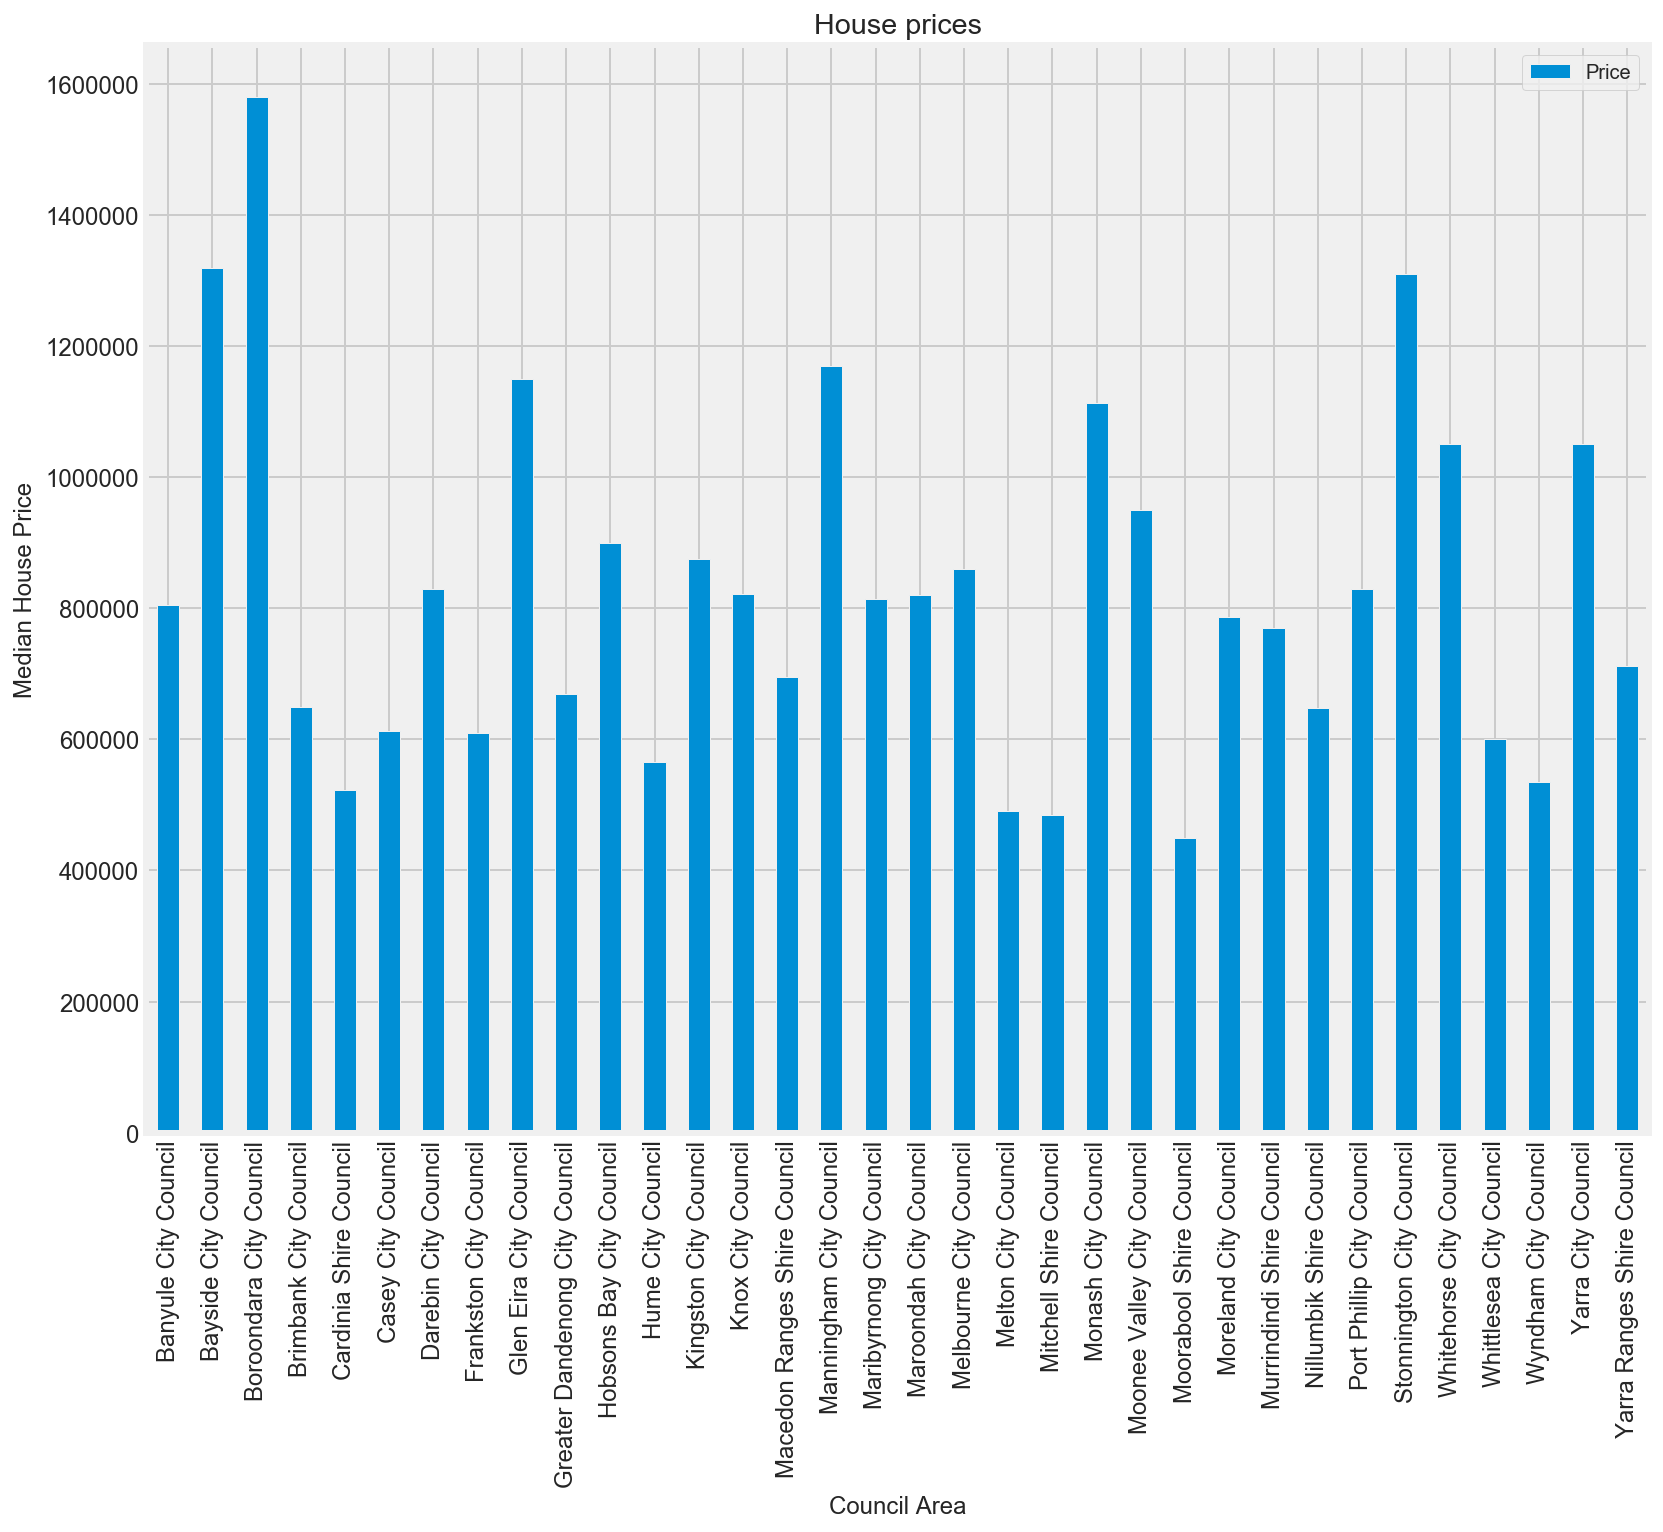

In [21]:
#df1.plot.bar(x='çouncil area',y='Price')

ax= df1.plot(kind='bar', title ="House prices", figsize=(12, 10), legend=True, fontsize=12)
ax.set_xlabel("Council Area",fontsize=12)
ax.set_ylabel("Median House Price",fontsize=12)


In [22]:
df1=house.groupby('CouncilArea')['Price'].median()
df1

CouncilArea
Banyule City Council               805000.0
Bayside City Council              1320000.0
Boroondara City Council           1580000.0
Brimbank City Council              650000.0
Cardinia Shire Council             522750.0
Casey City Council                 613000.0
Darebin City Council               830000.0
Frankston City Council             610000.0
Glen Eira City Council            1150000.0
Greater Dandenong City Council     670000.0
Hobsons Bay City Council           900000.0
Hume City Council                  565000.0
Kingston City Council              875000.0
Knox City Council                  822000.0
Macedon Ranges Shire Council       695000.0
Manningham City Council           1170000.0
Maribyrnong City Council           815000.0
Maroondah City Council             820000.0
Melbourne City Council             860000.0
Melton City Council                490000.0
Mitchell Shire Council             484000.0
Monash City Council               1113000.0
Moonee Valley City C

In [23]:
house.describe()

Rooms         Price      Postcode  Propertycount      Distance  \
count  48433.000000  4.843300e+04  48433.000000   48433.000000  48433.000000   
mean       3.071666  9.978982e+05   3123.191398    7566.399913     12.702761   
std        0.944708  5.934989e+05    125.475305    4457.405884      7.550030   
min        1.000000  8.500000e+04   3000.000000      39.000000      0.000000   
25%        2.000000  6.200000e+05   3051.000000    4280.000000      7.000000   
50%        3.000000  8.300000e+05   3103.000000    6567.000000     11.700000   
75%        4.000000  1.220000e+06   3163.000000   10412.000000     16.700000   
max       31.000000  1.120000e+07   3980.000000   21650.000000     55.800000   

           latitude     longitude  
count  48433.000000  48433.000000  
mean     -23.651077     90.712265  
std       18.299145     70.184612  
min      -38.221207      0.000000  
25%      -37.830343      0.000000  
50%      -37.721929    144.915178  
75%        0.000000    145.050867  
max        0.000000    145.602886

In [24]:
#dropping the outlier



house.drop(house[house['Rooms'] > 10].index, inplace = True) 

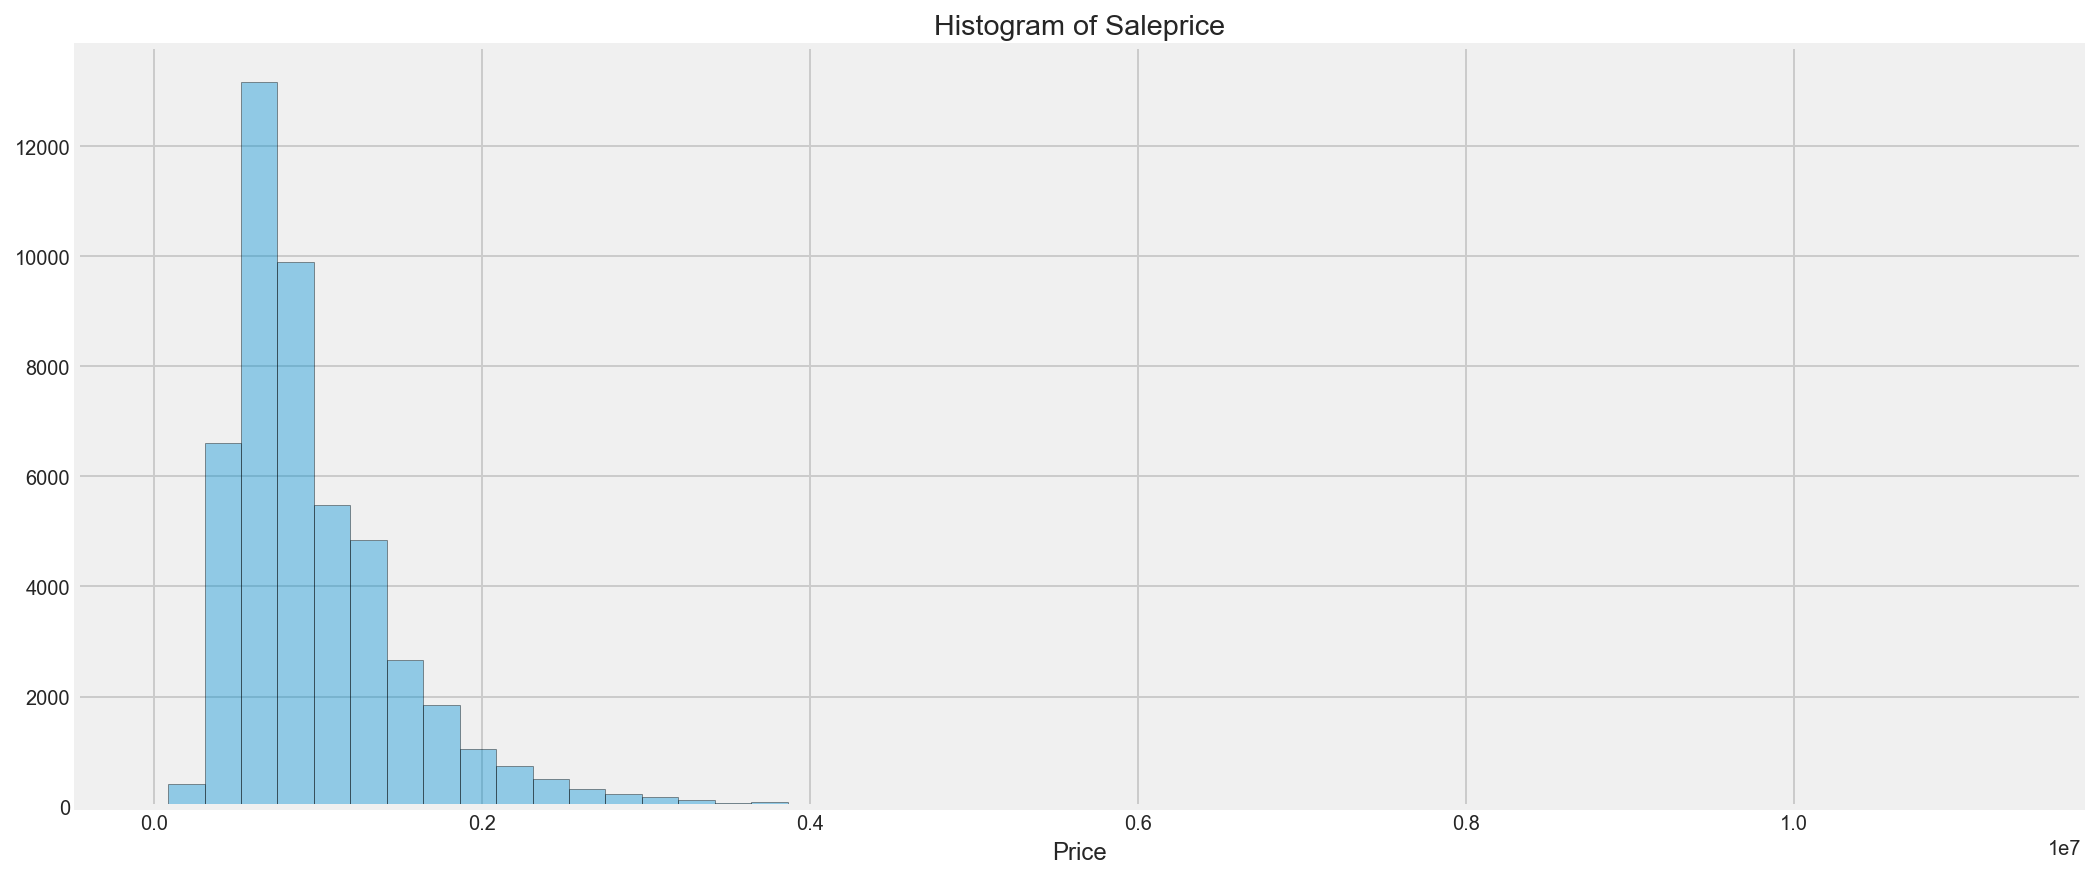

In [25]:
# plt.hist(house.Price, color = 'blue', edgecolor = 'black',bins = 50)
# plt.title('Histogram of Saleprice')

# plt.xlabel('Sale Price')

plt.figure(figsize=(16,7))
plt.xlabel('Sale Price')
plt.title('Histogram of Saleprice')
sns.distplot(house.Price,kde=False,hist_kws=dict(edgecolor="k"))

In [26]:
house.corr()

Rooms     Price  Postcode  Propertycount  Distance  \
Rooms          1.000000  0.414682  0.092801      -0.057997  0.282114   
Price          0.414682  1.000000  0.003283      -0.060904 -0.253786   
Postcode       0.092801  0.003283  1.000000      -0.000711  0.504204   
Propertycount -0.057997 -0.060904 -0.000711       1.000000  0.007693   
Distance       0.282114 -0.253786  0.504204       0.007693  1.000000   
latitude      -0.038706 -0.043613 -0.018334      -0.019264 -0.016164   
longitude      0.038906  0.043077  0.018092       0.019360  0.015943   

               latitude  longitude  
Rooms         -0.038706   0.038906  
Price         -0.043613   0.043077  
Postcode      -0.018334   0.018092  
Propertycount -0.019264   0.019360  
Distance      -0.016164   0.015943  
latitude       1.000000  -0.999991  
longitude     -0.999991   1.000000

## Reading the School Data with longitude and latitude

In [27]:
#data2= 'dv279-schoollocations2019.csv'

data2= 'dv165-allschoolslocationlist2015.csv'

In [28]:
school=pd.read_csv(data2,encoding='ISO-8859–1')


In [29]:

school.head(5)


Education_Sector  Entity_Type  School_No  \
0       Government            1          1   
1       Government            1          3   
2       Government            1          4   
3       Government            1          8   
4       Government            1         12   

                              School_Name School_Type School_Status  \
0                 Alberton Primary School     Primary             O   
1  Allansford and District Primary School     Primary             O   
2                    Avoca Primary School     Primary             O   
3                   Avenel Primary School     Primary             O   
4               Warrandyte Primary School     Primary             O   

       Address_Line_1 Address_Line_2 Address_Town Address_State  ...  \
0      Thomson Street            NaN     Alberton           VIC  ...   
1        Frank Street            NaN   Allansford           VIC  ...   
2  118 Barnett Street            NaN        Avoca           VIC  ...   
3  40 Anderson Street            NaN       Avenel           VIC  ...   
4  5-11 Forbes Street            NaN   Warrandyte           VIC  ...   

   Postal_Address_Line_1 Postal_Address_Line_2 Postal_Town Postal_State  \
0         Thomson Street                   NaN    ALBERTON          VIC   
1           Frank Street                   NaN  ALLANSFORD          VIC   
2             P O Box 12                   NaN       AVOCA          VIC   
3     40 Anderson Street                   NaN      AVENEL          VIC   
4     5-11 Forbes Street                   NaN  WARRANDYTE          VIC   

  Postal_Postcode  Full_Phone_No LGA_ID         LGA_Name           X  \
0            3971   03 5183 2412    681   Wellington (S)  146.666601   
1            3277   03 5565 1382    673  Warrnambool (C)  142.590393   
2            3467   03 5465 3176    599     Pyrenees (S)  143.475649   
3            3664   03 5796 2264    643  Strathbogie (S)  145.234722   
4            3113   03 9844 3537    421   Manningham (C)  145.213980   

           Y  
0 -38.617713  
1 -38.386281  
2 -37.084502  
3 -36.901368  
4 -37.742675  

[5 rows x 21 columns]

In [30]:
school.columns


Index(['Education_Sector', 'Entity_Type', 'School_No', 'School_Name',
       'School_Type', 'School_Status', 'Address_Line_1', 'Address_Line_2',
       'Address_Town', 'Address_State', 'Address_Postcode',
       'Postal_Address_Line_1', 'Postal_Address_Line_2', 'Postal_Town',
       'Postal_State', 'Postal_Postcode', 'Full_Phone_No', 'LGA_ID',
       'LGA_Name', 'X', 'Y'],
      dtype='object')

In [31]:
school.shape


(2232, 21)

In [32]:
school.Education_Sector.unique()


array(['Government', 'Independent', 'Catholic'], dtype=object)

In [33]:
school.isnull().sum()

Education_Sector            0
Entity_Type                 0
School_No                   0
School_Name                 0
School_Type                 0
School_Status               0
Address_Line_1              0
Address_Line_2           2223
Address_Town                0
Address_State               0
Address_Postcode            0
Postal_Address_Line_1       0
Postal_Address_Line_2    2220
Postal_Town                 0
Postal_State                0
Postal_Postcode             0
Full_Phone_No               0
LGA_ID                      0
LGA_Name                    0
X                           0
Y                           0
dtype: int64

In [34]:
school= school.drop(['Postal_Address_Line_2', 'Address_Line_2','Postal_Town','Full_Phone_No','LGA_ID'],axis=1)

In [35]:
try:
    school.set_index('School_Name',inplace=True)
except:
        pass

In [36]:
locations =  school.loc[school_rank_list,['Y','X']].dropna().to_dict(orient='items')
for loc in locations.items():
    print(loc)
    break

('Box Hill High School', {'Y': -37.820639, 'X': 145.137953})


## Loading the geojason file for school catchment area

In [37]:


geoschool = gpd.read_file('Secondary_Integrated_Year7_2020.geojson')
#setting the school name as index
try:
    geoschool = geoschool.set_index('School_Name').dropna()
except:
        pass



In [38]:
#Saving the top rank schools from geo dataframe into another dataframe
selected_school=geoschool.loc[school_rank_list,:].dropna()


In [39]:
selected_school=selected_school.dropna()

In [40]:
#converting the geometry to latitude and longitude points
geoschool = geoschool.to_crs(epsg=4326)
selected_school= selected_school.to_crs(epsg=4326)
# sele


In [41]:

try: 
    school_ranking.set_index('School Name',inplace=True)
except:
    pass 
#school_ranking['Ranking']

In [42]:
#Merging the 
selected_school = selected_school.merge(school_ranking[['Ranking']],left_index=True,right_index=True)

In [43]:
selected_school.head()

Campus_Name  ENTITY_CODE  \
Box Hill High School                Box Hill High School      1763501   
Balwyn High School                    Balwyn High School      1755001   
University High School            University High School      1840501   
Glen Waverley Secondary College              Glen Campus      1880801   
Mount Waverley Secondary College           Junior Campus      1810502   

                                 Year_Level Boundary_Year  \
Box Hill High School                      7          2020   
Balwyn High School                        7          2020   
University High School                    7          2020   
Glen Waverley Secondary College           7          2020   
Mount Waverley Secondary College          7          2020   

                                                                           geometry  \
Box Hill High School              POLYGON ((145.1330644741046 -37.84443816391551...   
Balwyn High School                POLYGON ((145.0915236807919 -37.77975573076034...   
University High School            POLYGON ((144.9480052219421 -37.8234748956609,...   
Glen Waverley Secondary College   POLYGON ((145.1573235832189 -37.86327285849145...   
Mount Waverley Secondary College  POLYGON ((145.1239018987548 -37.90215543161878...   

                                  Ranking  
Box Hill High School                    1  
Balwyn High School                      2  
University High School                  3  
Glen Waverley Secondary College         4  
Mount Waverley Secondary College        5

In [44]:
#To increase the size of polygon to include neighbouring houses

from shapely import affinity
poly = geoschool.loc[school_rank_list[9]].geometry
poly_n = affinity.scale(poly,xfact=1.0, yfact=1.0)


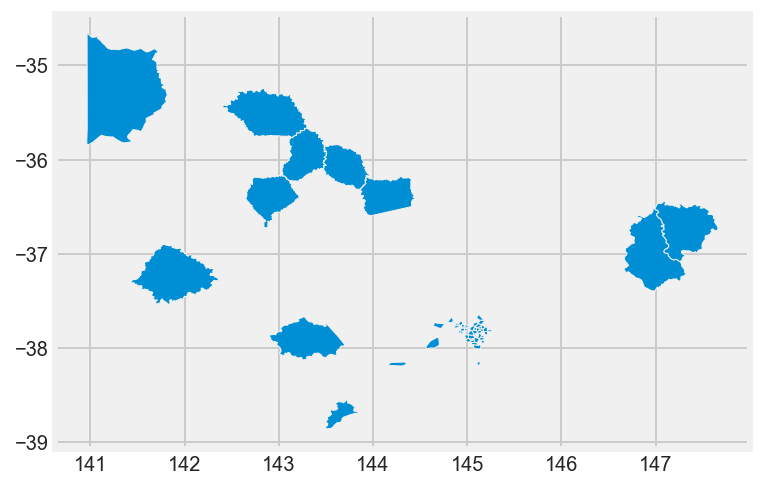

In [45]:
selected_school.plot()

In [46]:
# Finding the house mean price of all houses in each catchment zone.
selected_school['mean_price'] = selected_school.geometry.apply(lambda x: house[house.within(x)]['Price'].mean())

In [47]:
selected_school['mean_price'].dropna()

Box Hill High School                1.342294e+06
Balwyn High School                  1.885341e+06
University High School              1.141006e+06
Glen Waverley Secondary College     1.494678e+06
Mount Waverley Secondary College    1.280638e+06
Mckinnon Secondary College          1.375420e+06
Albert Park College                 1.474090e+06
Viewbank College                    1.071960e+06
Vermont Secondary College           1.035301e+06
Northcote High School               1.186186e+06
Brighton Secondary College          1.691949e+06
Koonung Secondary College           1.582354e+06
East Doncaster Secondary College    1.266799e+06
Princes Hill Secondary College      1.285519e+06
Williamstown High School            1.619479e+06
Buckley Park College                1.137083e+06
Brentwood Secondary College         1.130978e+06
Frankston High School               8.572923e+05
Camberwell High School              1.777023e+06
Blackburn High School               1.109134e+06
Ringwood Secondary C

## Plotting the schools and catchment zones as polygons

In [48]:
#school_ranking.iloc[0,0]

school_ranking.loc['St Helena Secondary College', 'Ranking']

48

In [49]:
Melb_CBD = [-37.8124, 144.9623]
m = folium.Map(location = Melb_CBD)
%matplotlib inline
#To map selected schools into cbd map



for School_Name, location in locations.items():
         
    marker = folium.CircleMarker(location=[location['Y'],location['X']],color='blue',fill_color='blue',fill_opacity=0.1,
                                 radius=1,popup='School Name : '+ School_Name + 'Rank:'  ).add_to(m)
m                        

In [50]:
Melb_CBD = [-37.8124, 144.9623]
m = folium.Map(location = Melb_CBD)
%matplotlib inline
#To map selected schools into cbd map




folium.GeoJson(geoschool.loc[school_rank_list].dropna()).add_to(m)
for School_Name, location in locations.items(): 
        marker = folium.CircleMarker(location=[location['Y'],location['X']],color='blue',fill_color='blue',fill_opacity=0.1,
                                     radius=1,tooltip='School Name : '+ School_Name+
                                     ', Rank:'+ str(selected_school.Ranking[School_Name])).add_to(m)
        




# display the map
display(m)

## To find the houses near to the school but outside the catchment zone

### To plot the houses outside school polygon

In [54]:

%matplotlib inline
#To map selected schools into cbd map


def map_catchment_neighbours(school):
    Melb_CBD = [-37.8124, 144.9623]
    m = folium.Map(location = Melb_CBD)
    #increase the size of polygon to include neighbouring suburbs 
    poly = geoschool.loc[school].geometry
    poly_n = affinity.scale(poly,xfact=2.5, yfact=2.5)
    #find the neighbourning houses to catchment zone
    neigh = poly_n.symmetric_difference(poly)

    neighbours = house[house.geometry.apply(lambda x : x.within(neigh))]
    for location in neighbours.geometry.items():
            #add tooltip
            marker = folium.CircleMarker(location=[location[1].y,location[1].x],color='blue',fill_color='blue',fill_opacity=0.1,
                                     radius=1,tooltip=school+' Median House Price  '+str(neighbours.Price.median())).add_to(m)
    
            
            
            
            
                                    

    folium.GeoJson(poly).add_to(m)
    # display the map
    display(m)
    
    #changed geoschool to selected_school

### To display all houses just outside catchment zone

In [55]:


def df_catchment_neighbours(school):
    
    poly = geoschool.loc[school].geometry
    poly_n = affinity.scale(poly,xfact=2.5, yfact=1.5)
    neigh = poly_n.symmetric_difference(poly)

    neighbours = house[house.geometry.apply(lambda x : x.within(neigh))]
    
   
    return(neighbours.head())
    neighbours.Price.median()

In [56]:
#selected_school.crs['init']

### To list the houses in the neighborhood of school with rank 9

In [57]:
df_catchment_neighbours(school_rank_list[9])


Suburb         Address  Rooms Type      Price       Date  Postcode  \
12  Alphington    55 Fulham Rd      2    h  1675000.0  1/04/2017      3078   
13  Alphington  41 Toolangi Rd      4    h  2008000.0  1/04/2017      3078   
94   Brunswick    53 Amelia St      2    h   740000.0  1/04/2017      3056   
96   Brunswick    2 Cassels Rd      3    h   900000.0  1/04/2017      3056   
97   Brunswick      70 Gold St      4    h  1250000.0  1/04/2017      3056   

               Regionname  Propertycount  Distance            CouncilArea  \
12  Northern Metropolitan           2211       5.7   Darebin City Council   
13  Northern Metropolitan           2211       5.7   Darebin City Council   
94  Northern Metropolitan          11918       5.2  Moreland City Council   
96  Northern Metropolitan          11918       5.2  Moreland City Council   
97  Northern Metropolitan          11918       5.2  Moreland City Council   

                                              address   latitude   longitude  \
12    55 Fulham Rd,Alphington,3078,Victoria,Australia -37.770187  145.027917   
13  41 Toolangi Rd,Alphington,3078,Victoria,Australia -37.774845  145.029857   
94     53 Amelia St,Brunswick,3056,Victoria,Australia -37.775908  144.965810   
96     2 Cassels Rd,Brunswick,3056,Victoria,Australia -37.757079  144.959707   
97       70 Gold St,Brunswick,3056,Victoria,Australia -37.774140  144.954900   

                                  geometry  
12         POINT (145.0279171 -37.7701869)  
13         POINT (145.0298567 -37.7748445)  
94         POINT (144.9658104 -37.7759084)  
96  POINT (144.9597069 -37.75707929999999)  
97         POINT (144.9548997 -37.7741404)

In [58]:
# plot of houses in the neighborhood of school with rank 9

In [59]:
map_catchment_neighbours(school_rank_list[9])


In [58]:
house_Northcote=house[house.within(selected_school.geometry.loc['Northcote High School'])]
house_Northcote.Price.median()

1114000.0

In [59]:
map_catchment_neighbours(school_rank_list[0])

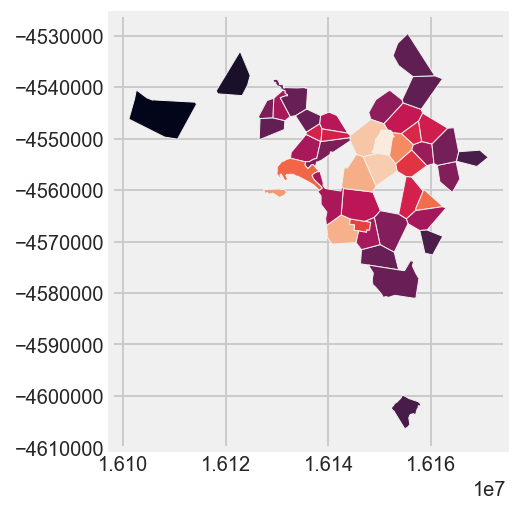

In [84]:
selected_school[selected_school.mean_price>600000].to_crs(epsg=3857).plot(column='mean_price')

In [87]:
selected_school.crs

{'init': 'epsg:4326', 'no_defs': True}

## To plot the heat map of catchment zones with average property price.

In [90]:
%matplotlib tk

In [92]:

import pandas_bokeh

In [94]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [101]:
from bokeh.models import BoxSelectTool


In [60]:
pandas_bokeh.output_notebook()

ax = selected_school[selected_school.mean_price>500000].reset_index()\
.plot_bokeh(figsize=(600,900),hovertool_columns=['index','Ranking','mean_price'],category='mean_price',colormap='Viridis',colormap_uselog=True,tile_provider="STAMEN_TERRAIN_RETINA")



Loading BokehJS ...

In [129]:
#selected_school

In [180]:
from folium import plugins
Melb_CBD = [-37.8124, 144.9623]
m = folium.Map(location = Melb_CBD)

#convert to (n, 2) nd-array format for heatmap
houseArr =house_new[['latitude', 'longitude']].as_matrix()

# plot heatmap
m.add_children(plugins.HeatMap(houseArr , radius=15))
m



In [134]:

df = gpd.GeoDataFrame(selected_school.to_crs(epsg=4326))

In [135]:
selected_school

Campus_Name  \
Box Hill High School                          Box Hill High School   
Balwyn High School                              Balwyn High School   
University High School                      University High School   
Glen Waverley Secondary College                        Glen Campus   
Mount Waverley Secondary College                     Junior Campus   
Mckinnon Secondary College              Mckinnon Secondary College   
Albert Park College                            Albert Park College   
Viewbank College                                  Viewbank College   
Vermont Secondary College                Vermont Secondary College   
Northcote High School                        Northcote High School   
Brighton Secondary College              Brighton Secondary College   
Koonung Secondary College                Koonung Secondary College   
East Doncaster Secondary College  East Doncaster Secondary College   
Princes Hill Secondary College      Princes Hill Secondary College   
Williamstown High School                            Bayview Campus   
Buckley Park College                          Buckley Park College   
Brentwood Secondary College            Brentwood Secondary College   
Frankston High School                                  7-10 Campus   
Apollo Bay P-12 College                    Apollo Bay P-12 College   
Camberwell High School                      Camberwell High School   
Tyrrell College                                    Tyrrell College   
Blackburn High School                        Blackburn High School   
Ringwood Secondary College              Ringwood Secondary College   
Murrayville Community College        Murrayville Community College   
East Loddon P-12 College                  East Loddon P-12 College   
Templestowe College                            Templestowe College   
Glen Eira College                                Glen Eira College   
Boort District P-12 School                    Malone Street Campus   
Kew High School                                    Kew High School   
Belmont High School                            Belmont High School   
Auburn High School                              Auburn High School   
Collingwood College                            Collingwood College   
Eltham High School                              Eltham High School   
Strathmore Secondary College          Strathmore Secondary College   
South Oakleigh Secondary College  South Oakleigh Secondary College   
Wellington Secondary College          Wellington Secondary College   
Cheltenham Secondary College          Cheltenham Secondary College   
Bright P-12 College                            Bright P-12 College   
Brunswick Secondary College            Brunswick Secondary College   
Mount Beauty Secondary College      Mount Beauty Secondary College   
Parkdale Secondary College              Parkdale Secondary College   
Werribee Secondary College              Werribee Secondary College   
Keilor Downs Secondary College      Keilor Downs Secondary College   
Doncaster Secondary College            Doncaster Secondary College   
Bentleigh Secondary College            Bentleigh Secondary College   
Fitzroy High School                            Fitzroy High School   
Brookside P-9 College                        Brookside P-9 College   
St Helena Secondary College            St Helena Secondary College   
Elwood College                                      Elwood College   
Mullauna Secondary College              Mullauna Secondary College   
Rosehill Secondary College              Rosehill Secondary College   
Donald High School                              Donald High School   
Derrinallum P-12 College                  Derrinallum P-12 College   
Wycheproof P-12 College                    Wycheproof P-12 College   
Maribyrnong Secondary College        Maribyrnong Secondary College   
Balmoral K-12 Community College    Balmoral K-12 Community College   

                                  ENTITY_CODE Year_Level Boundar

In [138]:
selected_school.iloc[1]

Campus_Name                                     Balwyn High School
ENTITY_CODE                                                1755001
Year_Level                                                       7
Boundary_Year                                                 2020
geometry         POLYGON ((145.0915236807919 -37.77975573076034...
Ranking                                                          2
mean_price                                             1.88534e+06
Name: Balwyn High School, dtype: object

In [139]:
#  house_selected= house[house.within(geoschool.geometry.loc[school_rank_list[1]])]

#     house_selected['School_Name']= school_rank_list[1]
#     house_selected['School_Rank']= 1


In [140]:
#school_ranking
geoschool

Campus_Name  ENTITY_CODE  \
School_Name                                                                   
Koo Wee Rup Secondary College    Koo Wee Rup Secondary College      1795501   
Pakenham Secondary College          Pakenham Secondary College      1822301   
Phoenix P-12 Community College               Sebastopol Campus      1890001   
Ballarat High School                      Ballarat High School      1754001   
Woodmans Hill Secondary College           Woodmans Hill Campus      1849101   
...                                                        ...          ...   
Charlton College                              Charlton College      1883001   
Boort District P-12 School                Malone Street Campus      1888201   
Cobden Technical School                Cobden Technical School      1708801   
Tyrrell College                                Tyrrell College      1540301   
Hopetoun P-12 College                    Hopetoun P-12 College      1890402   

                                Year_Level Boundary_Year  \
School_Name                                                
Koo Wee Rup Secondary College            7          2020   
Pakenham Secondary College               7          2020   
Phoenix P-12 Community College           7          2020   
Ballarat High School                     7          2020   
Woodmans Hill Secondary College          7          2020   
...                                    ...           ...   
Charlton College                         7          2020   
Boort District P-12 School               7          2020   
Cobden Technical School                  7          2020   
Tyrrell College                          7          2020   
Hopetoun P-12 College                    7          2020   

                                                                          geometry  
School_Name                                                                         
Koo Wee Rup Secondary College    POLYGON ((145.4463791534221 -38.1375046640577,...  
Pakenham Secondary College       POLYGON ((145.6593981013915 -38.11167020304855...  
Phoenix P-12 Community College   POLYGON ((143.5323444201563 -37.65872613716542...  
Ballarat High School             POLYGON ((143.8547513599577 -37.56183750519217...  
Woodmans Hill Secondary College  POLYGON ((143.8563401772289 -37.54562691164525...  
...                                                                            ...  
Charlton College                 POLYGON ((143.3886888705131 -36.45311345902385...  
Boort District P-12 School       POLYGON ((143.8583885943726 -36.31811084835292...  
Cobden Technical School          POLYGON ((143.350299849574 -38.45171506587093,...  
Tyrrell College                  POLYGON ((143.1191860443335 -35.76095058423078...  
Hopetoun P-12 College            POLYGON ((142.5017565385352 -35.98814391164657...  

[307 rows x 5 columns]

## Group all houses in each catchment zone and put to new dataframe

In [141]:
house_new=[]

for school in school_rank_list:
    #print(school)

    house_selected= house[house.within(geoschool.geometry.loc[school])]
   
    house_selected['School_Name']= school
    house_selected['School_Rank']= (school_rank_list.index(school))+1
    house_new.append(house_selected)
    
house_new=pd.concat(house_new)
house_new.to_csv('house_new.csv',index=False)


/anaconda3/envs/geoenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/envs/geoenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [142]:
house_new

Suburb           Address  Rooms Type      Price        Date  \
66           Blackburn     4 Rosalind Cr      3    h  1110000.0   1/04/2017   
69     Blackburn South     47A Canora St      3    h   980000.0   1/04/2017   
71     Blackburn South    34 Lawrence St      4    h  1925000.0   1/04/2017   
75            Box Hill   12/20 Ashted Rd      2    u   420000.0   1/04/2017   
593       Surrey Hills    11 Shepherd St      4    h  1600000.0   1/04/2017   
...                ...               ...    ...  ...        ...         ...   
61999      Maribyrnong    21 Mitchell St      3    h   820000.0  30/07/2016   
62000      Maribyrnong  3/4 Navigator St      2    u   330000.0  30/07/2016   
62675      Maribyrnong     51 MacEdon St      2    h  1250000.0  30/12/2017   
62677      Maribyrnong  5/127 Raleigh Rd      2    t   540000.0  30/12/2017   
62678      Maribyrnong       57 Wests Rd      3    t   625000.0  30/12/2017   

       Postcode             Regionname  Propertycount  Distance  \
66         3130   Eastern Metropolitan           5713      13.4   
69         3130   Eastern Metropolitan           4387      13.4   
71         3130   Eastern Metropolitan           4387      13.4   
75         3128   Eastern Metropolitan           4605      10.9   
593        3127  Southern Metropolitan           5457      10.2   
...         ...                    ...            ...       ...   
61999      3032   Western Metropolitan           4918       4.3   
62000      3032   Western Metropolitan           4918       4.3   
62675      3032   Western Metropolitan           4918       4.3   
62677      3032   Western Metropolitan           4918       4.3   
62678      3032   Western Metropolitan           4918       4.3   

                    CouncilArea  \
66      Whitehorse City Council   
69      Whitehorse City Council   
71      Whitehorse City Council   
75      Whitehorse City Council   
593     Boroondara City Council   
...                         ...   
61999  Maribyrnong City Council   
62000  Maribyrnong City Council   
62675  Maribyrnong City Council   
62677  Maribyrnong City Council   
62678  Maribyrnong City Council   

                                                 address   latitude  \
66       4 Rosalind Cr,Blackburn,3130,Victoria,Australia -37.828674   
69     47A Canora St,Blackburn South,3130,Victoria,Au... -37.838747   
71     34 Lawrence St,Blackburn South,3130,Victoria,A... -37.833800   
75      12/20 Ashted Rd,Box Hill,3128,Victoria,Australia -37.823375   
593    11 Shepherd St,Surrey Hills,3127,Victoria,Aust... -37.832355   
...                                                  ...        ...   
61999  21 Mitchell St,Maribyrnong,3032,Victoria,Austr... -37.783458   
62000  3/4 Navigator St,Maribyrnong,3032,Victoria,Aus... -37.765910   
62675  51 MacEdon St,Maribyrnong,3032,Victoria,Australia -37.780914   
62677  5/127 Raleigh Rd,Maribyrnong,3032,Victoria,Aus... -37.769076   
62678    57 Wests Rd,Maribyrnong,3032,Victoria,Australia -37.769917   

        longitude                                geometry  \
66     145.159281         POINT (145.1592808 -37.8286738)   
69     145.139885           POINT (145.139885 -37.838747)   
71     145.148541         POINT (145.1485407 -37.8337997)   
75     145.126563         POINT (145.1265634 -37.8233754)   
593    145.108516         POINT (145.1085159 -37.8323548)   
...           ...                                     ...   
61999  144.887546         POINT (144.8875464 -37.7834576)   
62000  144.898610  POINT (144.8986102 -37.76591029999999)   
62675  144.891468         POINT (144.8914676 -37.7809135)   
62677  144.886415          POINT (144.8864151 -37.769076)   
62678  144.882110          POINT (144.8821098 -37.769917)   

                         School_Name  School_Rank  
66              Box Hill High School            1  
69              Box Hill High School            1  
71              Box Hill High School            1  
75              Box Hill High School           

In [143]:
house_new.reset_index(drop=True)

Suburb           Address  Rooms Type      Price        Date  \
0            Blackburn     4 Rosalind Cr      3    h  1110000.0   1/04/2017   
1      Blackburn South     47A Canora St      3    h   980000.0   1/04/2017   
2      Blackburn South    34 Lawrence St      4    h  1925000.0   1/04/2017   
3             Box Hill   12/20 Ashted Rd      2    u   420000.0   1/04/2017   
4         Surrey Hills    11 Shepherd St      4    h  1600000.0   1/04/2017   
...                ...               ...    ...  ...        ...         ...   
13345      Maribyrnong    21 Mitchell St      3    h   820000.0  30/07/2016   
13346      Maribyrnong  3/4 Navigator St      2    u   330000.0  30/07/2016   
13347      Maribyrnong     51 MacEdon St      2    h  1250000.0  30/12/2017   
13348      Maribyrnong  5/127 Raleigh Rd      2    t   540000.0  30/12/2017   
13349      Maribyrnong       57 Wests Rd      3    t   625000.0  30/12/2017   

       Postcode             Regionname  Propertycount  Distance  \
0          3130   Eastern Metropolitan           5713      13.4   
1          3130   Eastern Metropolitan           4387      13.4   
2          3130   Eastern Metropolitan           4387      13.4   
3          3128   Eastern Metropolitan           4605      10.9   
4          3127  Southern Metropolitan           5457      10.2   
...         ...                    ...            ...       ...   
13345      3032   Western Metropolitan           4918       4.3   
13346      3032   Western Metropolitan           4918       4.3   
13347      3032   Western Metropolitan           4918       4.3   
13348      3032   Western Metropolitan           4918       4.3   
13349      3032   Western Metropolitan           4918       4.3   

                    CouncilArea  \
0       Whitehorse City Council   
1       Whitehorse City Council   
2       Whitehorse City Council   
3       Whitehorse City Council   
4       Boroondara City Council   
...                         ...   
13345  Maribyrnong City Council   
13346  Maribyrnong City Council   
13347  Maribyrnong City Council   
13348  Maribyrnong City Council   
13349  Maribyrnong City Council   

                                                 address   latitude  \
0        4 Rosalind Cr,Blackburn,3130,Victoria,Australia -37.828674   
1      47A Canora St,Blackburn South,3130,Victoria,Au... -37.838747   
2      34 Lawrence St,Blackburn South,3130,Victoria,A... -37.833800   
3       12/20 Ashted Rd,Box Hill,3128,Victoria,Australia -37.823375   
4      11 Shepherd St,Surrey Hills,3127,Victoria,Aust... -37.832355   
...                                                  ...        ...   
13345  21 Mitchell St,Maribyrnong,3032,Victoria,Austr... -37.783458   
13346  3/4 Navigator St,Maribyrnong,3032,Victoria,Aus... -37.765910   
13347  51 MacEdon St,Maribyrnong,3032,Victoria,Australia -37.780914   
13348  5/127 Raleigh Rd,Maribyrnong,3032,Victoria,Aus... -37.769076   
13349    57 Wests Rd,Maribyrnong,3032,Victoria,Australia -37.769917   

        longitude                                geometry  \
0      145.159281         POINT (145.1592808 -37.8286738)   
1      145.139885           POINT (145.139885 -37.838747)   
2      145.148541         POINT (145.1485407 -37.8337997)   
3      145.126563         POINT (145.1265634 -37.8233754)   
4      145.108516         POINT (145.1085159 -37.8323548)   
...           ...                                     ...   
13345  144.887546         POINT (144.8875464 -37.7834576)   
13346  144.898610  POINT (144.8986102 -37.76591029999999)   
13347  144.891468         POINT (144.8914676 -37.7809135)   
13348  144.886415          POINT (144.8864151 -37.769076)   
13349  144.882110          POINT (144.8821098 -37.769917)   

                         School_Name  School_Rank  
0               Box Hill High School            1  
1               Box Hill High School            1  
2               Box Hill High School            1  
3               Box Hill High School           

## To select the houses within the catchment zone of school with highest rank.

In [253]:


#house[house.within(geoschool.geometry.loc[school_rank_list[2]])]

house_Northcote=house[house.within(selected_school.geometry.loc['Northcote High School'])]


In [254]:
#To select schools with in the catchment area of Balwyn high school


house_balwyn=house[house.within(selected_school.geometry.loc['Balwyn High School'])]

In [255]:
house_balwyn.Price.median()

1800000.0

In [147]:
#house_university_high=house[house.within(selected_school.geometry.loc['University High School'])]

In [148]:
house_new.Regionname= house_new.Regionname.map({'Northern Metropolitan':'N metro',
                                      'Southern Metropolitan': 'S Metro',
                                       'Western Metropolitan':'W Metro',
                                       'South-Eastern Metropolitan':'SE Metro',
                                       'Eastern Metropolitan':'E Metro',
                                       'Northern Victoria':'N Vic',
                                       'Western Victoria': 'W Vic',
                                       'Eastern Victoria': 'E Vic'})

In [149]:
house_new.CouncilArea = house_new.CouncilArea.map({ 'Yarra City Council':'Yarra', 'Moonee Valley City Council':'Moonee',
       'Brimbank City Council':'Brimbank', 'Port Phillip City Council':'Portphilip',
       'Darebin City Council':'darebin', 'Hobsons Bay City Council':'Hobsonsbay',
       'Stonnington City Council':'Stonington', 'Boroondara City Council':'Boroondara',
       'Monash City Council':'Monash', 'Kingston City Council':'Kingston',
       'Hume City Council':'Hume', 'Maroondah City Council':'Maroondah',
       'Bayside City Council':'Bayside', 'Banyule City Council':'Banyule',
       'Glen Eira City Council':'GlenEira', 'Whitehorse City Council':'Whitehorse',
       'Knox City Council':'Knox', 'Maribyrnong City Council':'Maribyrnong',
       'Moreland City Council':'Moreland', 'Manningham City Council':'Manningham',
       'Melbourne City Council':'Melbcity', 'Melton City Council':'Meltoncity',
       'Frankston City Council':'Frankston', 'Macedon Ranges Shire Council':'Macedon',
       'Casey City Council':'Casey', 'Greater Dandenong City Council':'Dandenong',
       'Moorabool Shire Council':'Moorabool', 'Nillumbik Shire Council':'Nilumbik',
       'Whittlesea City Council':'Whittlesea', 'Wyndham City Council':'Wyndham',
       'Yarra Ranges Shire Council':'Yarra', 'Cardinia Shire Council':'Cardinia',
       'Mitchell Shire Council':'Mitchell', 'Murrindindi Shire Council':'Murrindindi'})

In [150]:
house_new=pd.get_dummies(house_new,columns=['Regionname','CouncilArea','Type'],drop_first=True)

In [151]:
house_new_test=house_new[house_new.Date.str.contains('2018')]

In [152]:
house_new_train1= house_new[house_new.Date.str.contains('2017')]

In [153]:
house_new_train2= house_new[house_new.Date.str.contains('2016')]

In [154]:
house_new_train= pd.concat([house_new_train2,house_new_train1],axis=0 )

In [155]:
house_new_train.shape

(9405, 45)

In [194]:
X_train= house_new_train.drop(['Suburb','Address','Price','Date','address','geometry','School_Name'],axis=1)

In [195]:
X_train.columns

Index(['Rooms', 'Postcode', 'Propertycount', 'Distance', 'latitude',
       'longitude', 'School_Rank', 'Regionname_N Vic', 'Regionname_N metro',
       'Regionname_S Metro', 'Regionname_SE Metro', 'Regionname_W Metro',
       'CouncilArea_Bayside', 'CouncilArea_Boroondara', 'CouncilArea_Brimbank',
       'CouncilArea_Dandenong', 'CouncilArea_Frankston',
       'CouncilArea_GlenEira', 'CouncilArea_Hobsonsbay',
       'CouncilArea_Kingston', 'CouncilArea_Knox', 'CouncilArea_Manningham',
       'CouncilArea_Maribyrnong', 'CouncilArea_Maroondah',
       'CouncilArea_Melbcity', 'CouncilArea_Meltoncity', 'CouncilArea_Monash',
       'CouncilArea_Moonee', 'CouncilArea_Moreland', 'CouncilArea_Nilumbik',
       'CouncilArea_Portphilip', 'CouncilArea_Stonington',
       'CouncilArea_Whitehorse', 'CouncilArea_Wyndham', 'CouncilArea_Yarra',
       'CouncilArea_darebin', 'Type_t', 'Type_u'],
      dtype='object')

In [196]:
X_test=house_new_test.drop(['Suburb','Address','Price','Date','address','geometry','School_Name'],axis=1)

In [197]:
#X_test=pd.get_dummies(X_test,columns=['Regionname','CouncilArea','Type'],drop_first=True)

In [198]:
X_test.columns

Index(['Rooms', 'Postcode', 'Propertycount', 'Distance', 'latitude',
       'longitude', 'School_Rank', 'Regionname_N Vic', 'Regionname_N metro',
       'Regionname_S Metro', 'Regionname_SE Metro', 'Regionname_W Metro',
       'CouncilArea_Bayside', 'CouncilArea_Boroondara', 'CouncilArea_Brimbank',
       'CouncilArea_Dandenong', 'CouncilArea_Frankston',
       'CouncilArea_GlenEira', 'CouncilArea_Hobsonsbay',
       'CouncilArea_Kingston', 'CouncilArea_Knox', 'CouncilArea_Manningham',
       'CouncilArea_Maribyrnong', 'CouncilArea_Maroondah',
       'CouncilArea_Melbcity', 'CouncilArea_Meltoncity', 'CouncilArea_Monash',
       'CouncilArea_Moonee', 'CouncilArea_Moreland', 'CouncilArea_Nilumbik',
       'CouncilArea_Portphilip', 'CouncilArea_Stonington',
       'CouncilArea_Whitehorse', 'CouncilArea_Wyndham', 'CouncilArea_Yarra',
       'CouncilArea_darebin', 'Type_t', 'Type_u'],
      dtype='object')

In [232]:
y_train= np.log(house_new_train['Price'])

In [233]:
y_test= np.log(house_new_test['Price'])

In [234]:
lr= LinearRegression()

In [235]:
model=lr.fit(X_train,y_train)

In [236]:
y_hat= model.predict(X_test)

In [237]:
#X_test= ss.fit_transform(X_test)

In [238]:
model.score(X_test,y_test)


0.7166052888350074

In [239]:
#baseline accuracy
import numpy as np
print(np.mean(y_test))

13.908696036491602


In [240]:
#using decision tree model
from sklearn.tree import DecisionTreeRegressor 
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)
    

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [241]:
dtr.score(X_train,y_train)

0.97564231709087

In [242]:
dtr.predict(X_test)

array([13.63757935, 14.62644077, 13.9552725 , ..., 13.98525333,
       14.30101837, 12.92391244])

In [243]:
dtr.score(X_test,y_test)

0.6385904289524647

In [244]:
from sklearn.ensemble import RandomForestRegressor

In [245]:
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [246]:
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [247]:
rfr.score(X_train,y_train)

0.9440906922413067

In [248]:
rfr.predict(X_test)

array([13.54021166, 14.43469658, 13.95613831, ..., 13.94912239,
       14.04569992, 12.92550944])

In [249]:
rfr.score(X_test,y_test)

0.7542055017206558

In [252]:
corr_list = sorted(house_new.corr().to_dict()['Price'].items(), key=lambda x: x[1], reverse=True)
corr_list

[('Price', 1.0),
 ('Rooms', 0.553266618353834),
 ('CouncilArea_Boroondara', 0.2663888812339197),
 ('Regionname_S Metro', 0.24193854766030476),
 ('CouncilArea_Stonington', 0.15702600548942464),
 ('CouncilArea_Bayside', 0.11952811640478087),
 ('Postcode', 0.08435435043981289),
 ('CouncilArea_Hobsonsbay', 0.03883876389426184),
 ('longitude', 0.03671401669613416),
 ('Propertycount', 0.007073860934820803),
 ('CouncilArea_Knox', 0.00106644315624362),
 ('CouncilArea_Melbcity', -0.010395717868380018),
 ('Regionname_N Vic', -0.012552058585129627),
 ('CouncilArea_Manningham', -0.013968530401294796),
 ('latitude', -0.014957051358922705),
 ('CouncilArea_Nilumbik', -0.014986140598527134),
 ('CouncilArea_Yarra', -0.017104866809713633),
 ('CouncilArea_Monash', -0.020364714992040813),
 ('CouncilArea_Portphilip', -0.020560178476019233),
 ('CouncilArea_darebin', -0.025047581506733),
 ('CouncilArea_Dandenong', -0.033719311284678824),
 ('CouncilArea_Meltoncity', -0.034289791161245614),
 ('CouncilArea_Whit

In [251]:
feature_importances = pd.DataFrame(dtr.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)


importance
Type_u                0.361005
Rooms                 0.159124
latitude              0.116131
longitude             0.100466
Regionname_S Metro    0.091418
Distance              0.087565
Type_t                0.022557
School_Rank           0.019097
Propertycount         0.016805
Postcode              0.009005

In [287]:
house_new.tail(100)

Suburb             Address  Rooms      Price        Date  \
44074  Maribyrnong    1/10 Newstead St      2   400000.0  22/09/2018   
44075  Maribyrnong  405/7 Ordnance Res      3   657000.0  22/09/2018   
44549  Maribyrnong        16 Amarco Cr      4   880000.0  23/04/2016   
44550  Maribyrnong        2 Murnong St      4  1048700.0  23/04/2016   
44682   Ascot Vale       43 Dalgety Dr      4  1380000.0  23/06/2018   
...            ...                 ...    ...        ...         ...   
61999  Maribyrnong      21 Mitchell St      3   820000.0  30/07/2016   
62000  Maribyrnong    3/4 Navigator St      2   330000.0  30/07/2016   
62675  Maribyrnong       51 MacEdon St      2  1250000.0  30/12/2017   
62677  Maribyrnong    5/127 Raleigh Rd      2   540000.0  30/12/2017   
62678  Maribyrnong         57 Wests Rd      3   625000.0  30/12/2017   

       Postcode  Propertycount  Distance  \
44074      3032           4918       4.3   
44075      3032           4918       4.3   
44549      3032           4918       4.3   
44550      3032           4918       4.3   
44682      3032           6567       4.3   
...         ...            ...       ...   
61999      3032           4918       4.3   
62000      3032           4918       4.3   
62675      3032           4918       4.3   
62677      3032           4918       4.3   
62678      3032           4918       4.3   

                                                 address   latitude  ...  \
44074  1/10 Newstead St,Maribyrnong,3032,Victoria,Aus... -37.769466  ...   
44075  405/7 Ordnance Res,Maribyrnong,3032,Victoria,A... -37.770589  ...   
44549   16 Amarco Cr,Maribyrnong,3032,Victoria,Australia -37.785540  ...   
44550   2 Murnong St,Maribyrnong,3032,Victoria,Australia -37.773996  ...   
44682   43 Dalgety Dr,Ascot Vale,3032,Victoria,Australia -37.777956  ...   
...                                                  ...        ...  ...   
61999  21 Mitchell St,Maribyrnong,3032,Victoria,Austr... -37.783458  ...   
62000  3/4 Navigator St,Maribyrnong,3032,Victoria,Aus... -37.765910  ...   
62675  51 MacEdon St,Maribyrnong,3032,Victoria,Australia -37.780914  ...   
62677  5/127 Raleigh Rd,Maribyrnong,3032,Victoria,Aus... -37.769076  ...   
62678    57 Wests Rd,Maribyrnong,3032,Victoria,Australia -37.769917  ...   

       CouncilArea_Nilumbik CouncilArea_Portphilip CouncilArea_Stonington  \
44074                     0                      0                      0   
44075                     0                      0                      0   
44549                     0                      0                      0   
44550                     0                      0                      0   
44682                     0                      0                      0   
...                     ...                    ...                    ...   
61999                     0                      0                      0   
62000                     0                      0                      0   
62675                     0                      0                      0   
62677                     0                      0                      0   
62678                     0                      0                      0   

       CouncilArea_Whitehorse  CouncilArea_Wyndham  CouncilArea_Yarra  \
44074                       0                    0                  0   
44075                       0                    0                  0   
44549                       0                    0                  0   
44550                       0                    0                  0   
44682                       0                    0                  0   
...                       ...                  ...                ...   
61999                       0                    0                  0   
62000                       0                    0                  0   
62675                       0                    0                  0   
62677                       0                    0